In [21]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import re


# Load data:
with pd.ExcelFile("../data/raw/Data AA Graph.xlsx") as xlsx:
    omset_df = pd.read_excel(xlsx, "Omset")
    data_df = pd.read_excel(xlsx, "Data")

In [4]:
# Check data type:
display(omset_df.info())
display(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22224 entries, 0 to 22223
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Thn     22224 non-null  int64  
 1   Bln     22224 non-null  int64  
 2   KdWil   22224 non-null  int64  
 3   KetWil  22224 non-null  object 
 4   KP      22224 non-null  object 
 5   QtyKrt  22224 non-null  float64
 6   Rp      22224 non-null  float64
 7   EC      22224 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.4+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14638 entries, 0 to 14637
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Wilayah  14638 non-null  object        
 1   Product  14638 non-null  object        
 2   Unit     8926 non-null   object        
 3   Dimensi  14638 non-null  object        
 4   Periode  14638 non-null  datetime64[ns]
 5   Value    14638 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 686.3+ KB


None

# Assumptions
Current Marketing Spend, Promotional Spend, Percentage etc. Affects the Current Revenue

# Data Preprocessing

In [29]:
from itertools import product

# Constant 
START_DATE = '2015-01-01'
END_DATE = '2024-03-01'

# Preprocess Omset
def preprocess_omset(df):
    # 1. Create `Periode` column (%Y-%m-%d)
    df['Periode'] = pd.to_datetime(df['Thn'].astype(str) + '-' + df['Bln'].astype(str) + '-01')
    df = df.drop(columns=['Thn', 'Bln'])
    df['KP'] = df['KP'].str.upper()

    # 2. Groupby sum aggregation by `Periode` and `KP`
    df = df.groupby(by=['Periode', 'KP']).agg({'QtyKrt': 'sum', 'Rp': 'sum', 'EC': 'sum'}).reset_index()

    # 3. Filter to only use data until 01-03-2024
    df = df[df['Periode']<=END_DATE]

    # 4. Add zeros for missing values between '2015-01-01' and '2024-03-01'
    kp = df['KP'].unique()
    date_ranges = pd.date_range(start=START_DATE, end=END_DATE, freq='MS')

    complete_date_df = pd.DataFrame(product(date_ranges, kp), columns=['Periode', 'KP'])
    df = complete_date_df.merge(df, how='left', on=['Periode', 'KP']).fillna(0)

    return df

cleaned_omset_df = preprocess_omset(omset_df.copy())

# Preprocess Advertising data
advertising_df = data_df.copy()
advertising_df['Dimensi'] = advertising_df['Dimensi'].str.title()
advertising_df = advertising_df[advertising_df['Dimensi'].str.match("Advertising")]

def preprocess_advertising(df):
    # 1. Rename column from `Product` to `KP`
    df = df.rename(columns={"Product": "KP"})
    df['KP'] = df['KP'].str.upper()
    
    # 2. Change unit of scale from 'Puluhan Jt Rp' TO 'Jt Rupiah'
    def change_unit_scale(row):
        if row['Dimensi'] == 'Advertising Spend (Puluhan Jt Rp)':
            row['Value'] = row['Value'] * 10_000_000
            row['Dimensi'] = 'Advertising Spend (Rp)'
        elif row['Dimensi'] == 'Advertising Spend (Jt Rp)':
            row['Value'] = row['Value'] * 1_000_000
            row['Dimensi'] = 'Advertising Spend (Rp)'
        return row
    df = df.apply(change_unit_scale, axis=1)
    
    # 3. Filter to only use data until 01-03-2024
    df = df[df['Periode']<=END_DATE]

    # 4. Feature engineering
    df['Price Per Product'] = cleaned_omset_df['Rp'] / cleaned_omset_df['QtyKrt']
    return df

cleaned_advertising_df = preprocess_advertising(advertising_df.copy())

# Data Verification
Verify Date ranges from January 2015 - March 2024 (111 months)

In [30]:
print("Minimum and Maximum Date")
display(cleaned_omset_df.groupby('KP').agg({'Periode': ['min', 'max']}))
print("Periode (Date) Count")
display(cleaned_omset_df.groupby('KP').agg({'Periode': 'count'}))

Minimum and Maximum Date


Periode           
                     min        max
KP                                 
CRYSTALIN     2015-01-01 2024-03-01
KIRANTI       2015-01-01 2024-03-01
SG FORMULA    2015-01-01 2024-03-01
TANGO WAFER   2015-01-01 2024-03-01
TEH GELAS CUP 2015-01-01 2024-03-01

Periode (Date) Count


,Periode
KP,
CRYSTALIN,111
KIRANTI,111
SG FORMULA,111
TANGO WAFER,111
TEH GELAS CUP,111


In [31]:
print("Minimum and Maximum Date")
display(cleaned_advertising_df.groupby('KP').agg({'Periode': ['min', 'max']}))
print("Periode (Date) Count")
display(cleaned_advertising_df.groupby('KP').agg({'Periode': 'count'}))

Minimum and Maximum Date


Periode           
                     min        max
KP                                 
CRYSTALIN     2015-01-01 2024-03-01
KIRANTI       2015-01-01 2024-03-01
SG FORMULA    2015-01-01 2024-03-01
TANGO WAFER   2015-01-01 2024-03-01
TEH GELAS CUP 2015-01-01 2024-03-01

Periode (Date) Count


,Periode
KP,
CRYSTALIN,111
KIRANTI,111
SG FORMULA,111
TANGO WAFER,111
TEH GELAS CUP,111


# Data Visualization

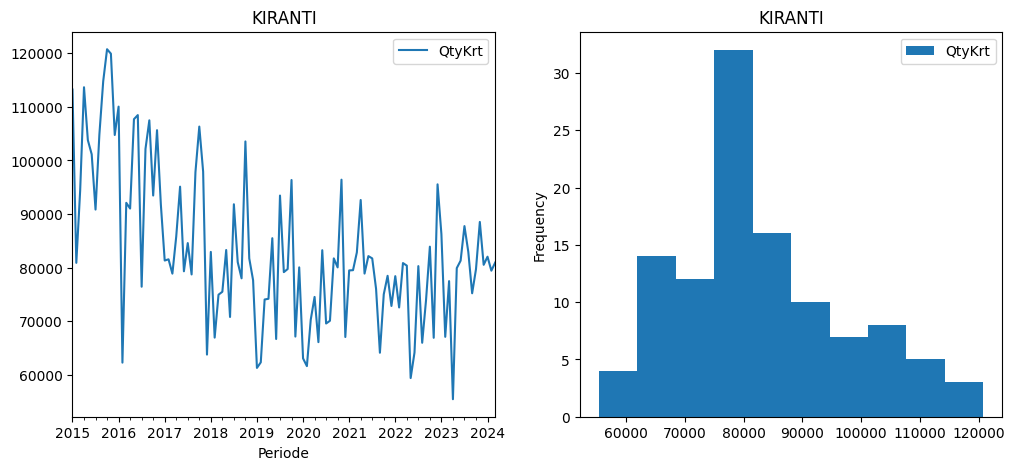

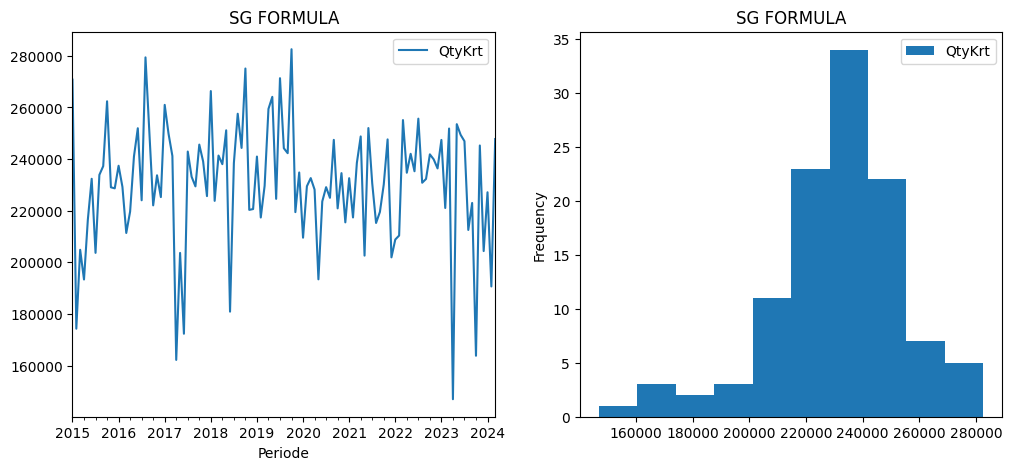

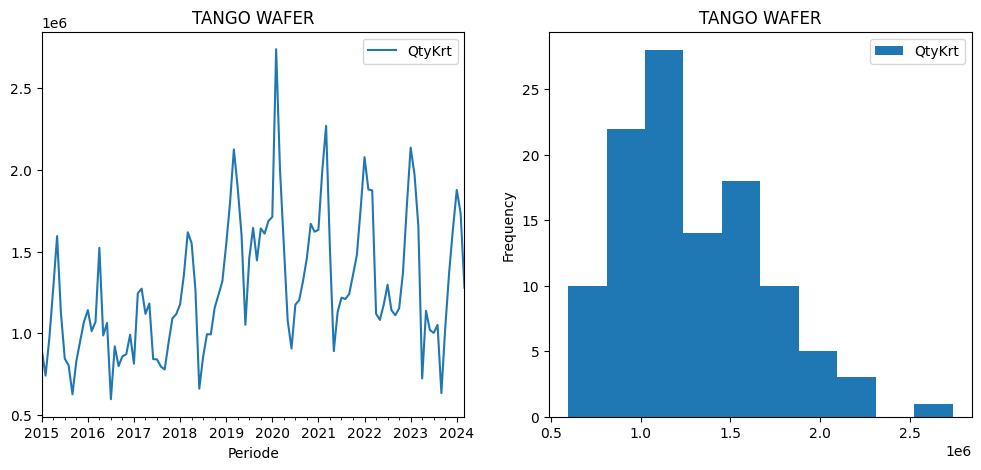

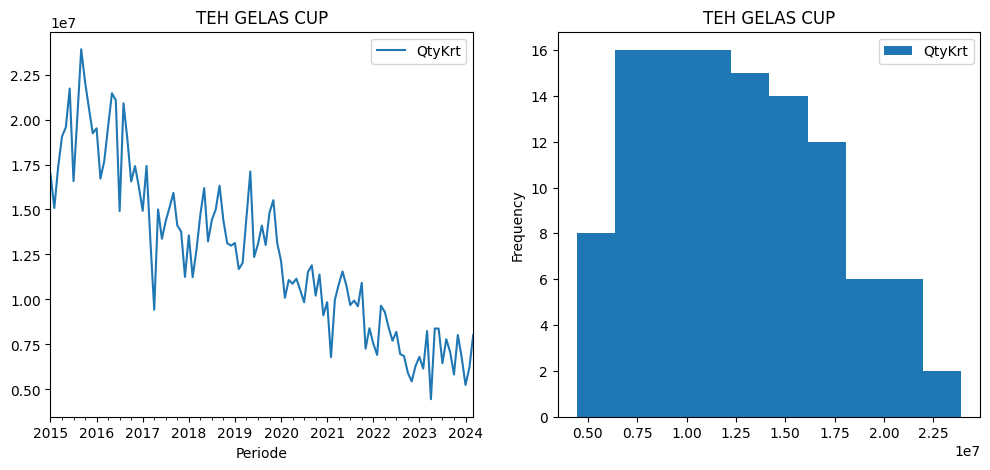

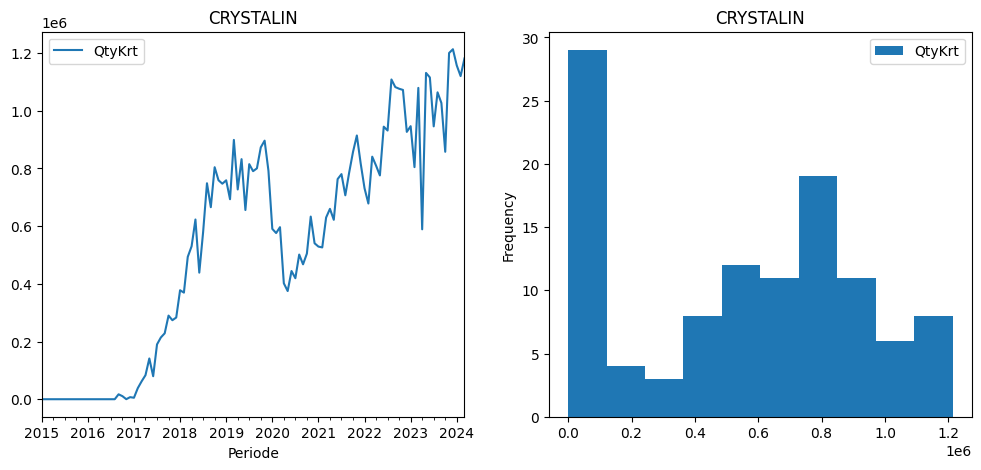

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

# Line and Distribution Plot
for col in cleaned_omset_df['KP'].unique():
    fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
    filter_ = cleaned_omset_df['KP'] == col
    cleaned_omset_df[filter_].plot(x='Periode', y='QtyKrt', title=col, ax=ax[0])
    cleaned_omset_df[filter_].plot(kind='hist', x='Periode', y='QtyKrt', title=col, ax=ax[1])
    plt.show()

# Advertising Spend and Revenue

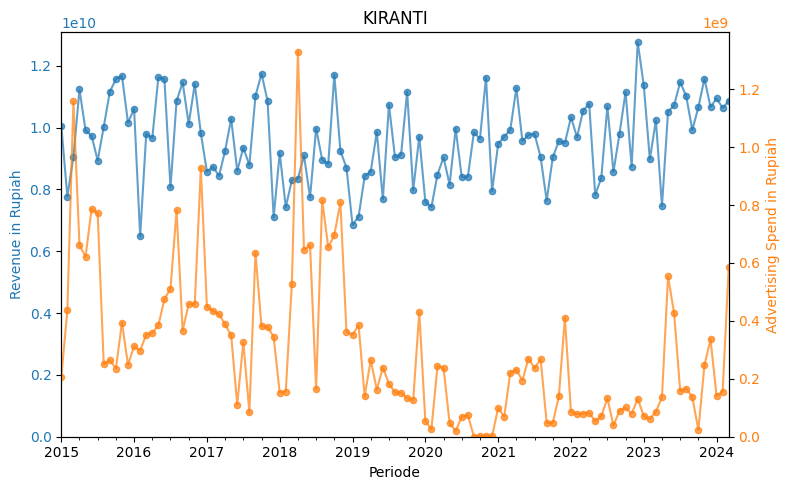

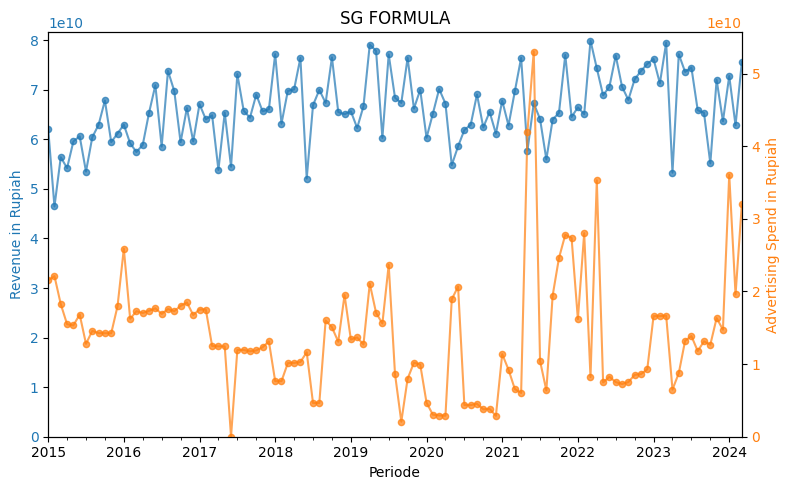

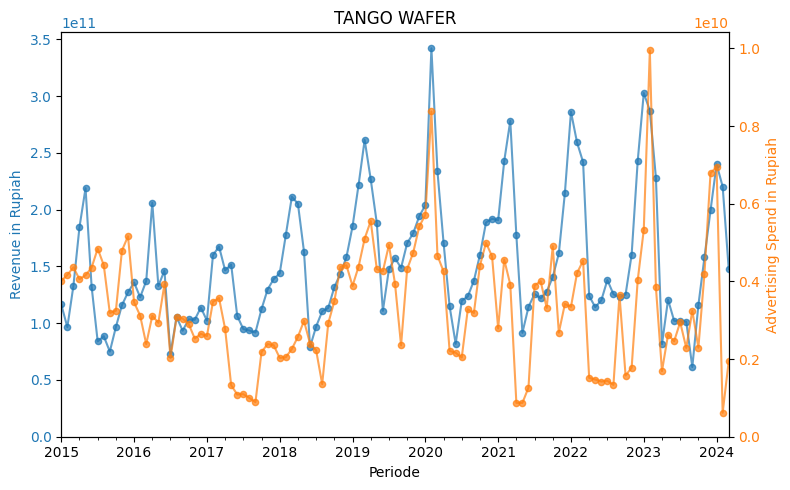

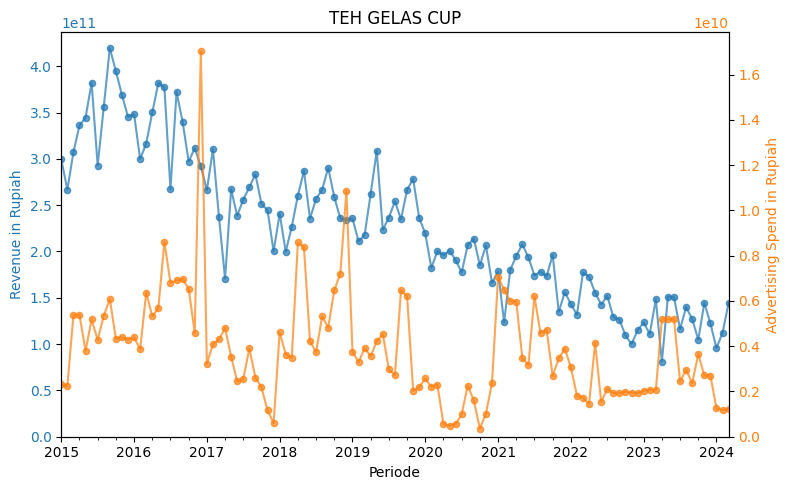

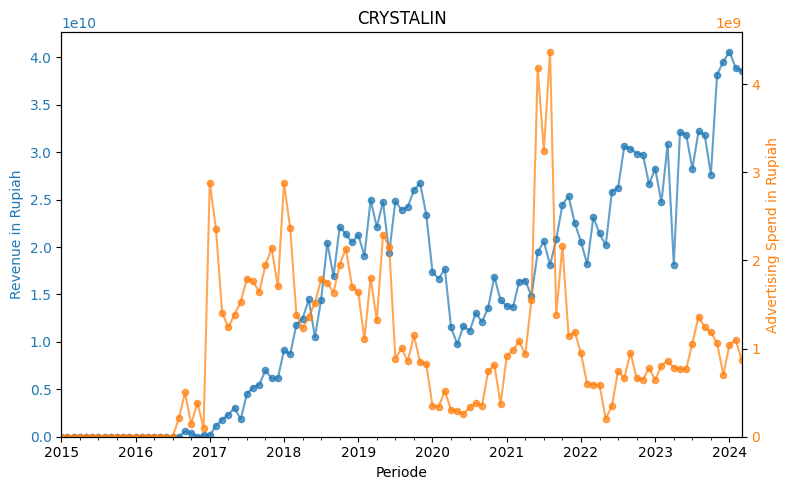

In [37]:
unique_kps = cleaned_omset_df['KP'].unique()

for kp in unique_kps:
    fig, ax1 = plt.subplots(figsize=(8, 5))

    color = 'tab:blue'
    filter_ = cleaned_omset_df['KP'] == kp
    cleaned_omset_df[filter_].plot(x='Periode', y='Rp', color=color, alpha=0.7, title=kp, ax=ax1)
    cleaned_omset_df[filter_].plot(kind='scatter', x='Periode', y='Rp', color=color, alpha=0.7, title=kp, legend=False, ax=ax1)
    ax1.set_xlabel('Periode')
    ax1.set_ylabel('Revenue in Rupiah', color=color)  # we already handled the x-label with ax1
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.get_legend().remove()
    ax1.set_ylim(0)

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    color = 'tab:orange'
    filter_ = cleaned_advertising_df['KP'] == kp
    cleaned_advertising_df[filter_].plot(x='Periode', y='Value', color=color, alpha=0.7, ax=ax2)
    cleaned_advertising_df[filter_].plot(kind='scatter', x='Periode', y='Value', color=color, alpha=0.7, legend=False, ax=ax2)
    ax2.set_ylabel('Advertising Spend in Rupiah', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.get_legend().remove()
    ax2.set_ylim(0)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

# Multicovariate Analysis between Advertising Spend and Revenue

In [40]:
# Assume that current marketing spend affects current revenue
subset_omset_df = cleaned_omset_df[['Periode', 'KP', 'Rp']].rename(columns={'Rp': 'Revenue in Rupiah'})
subset_advertising_df= cleaned_advertising_df[['Periode', 'KP', 'Value']].rename(columns={'Value': 'Ads Spend in Rupiah'})
experiment_df = subset_omset_df.merge(subset_advertising_df, on=['KP', 'Periode'])

In [41]:
kiranti_df = experiment_df.copy()[experiment_df['KP']=='KIRANTI']
sg_formula_df = experiment_df.copy()[experiment_df['KP']=='SG FORMULA']
tango_wafer_df = experiment_df.copy()[experiment_df['KP']=='TANGO WAFER']
teh_gelas_cup_df = experiment_df.copy()[experiment_df['KP']=='TEH GELAS CUP']
crystalin_df = experiment_df.copy()[experiment_df['KP']=='CRYSTALIN']

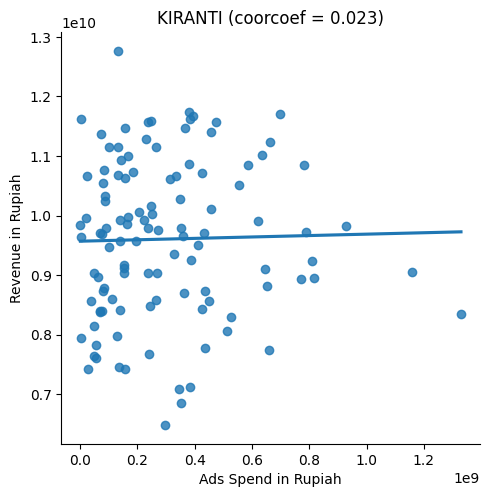

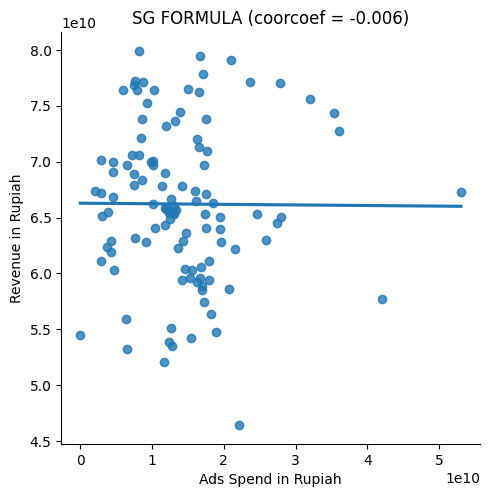

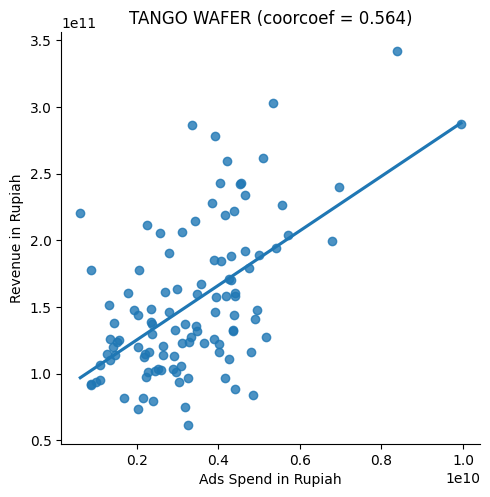

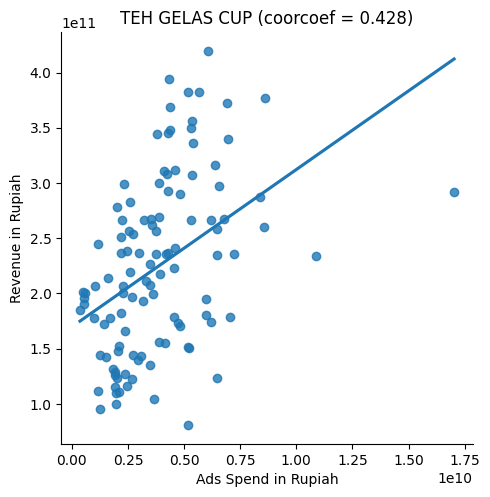

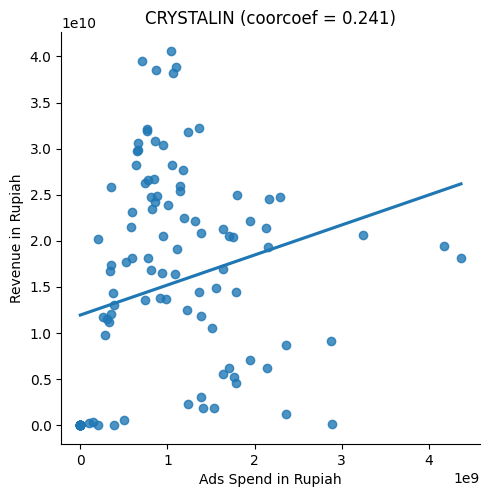

In [53]:
import seaborn as sns
for kp in experiment_df['KP'].unique():
    
    sns.lmplot(data=experiment_df[experiment_df['KP']==kp], x='Ads Spend in Rupiah', y='Revenue in Rupiah', ci=False)
    corrcoef = np.corrcoef(
        experiment_df.loc[experiment_df['KP']==kp, 'Ads Spend in Rupiah'], 
        experiment_df.loc[experiment_df['KP']==kp, 'Revenue in Rupiah']
    ).tolist()[1][0]
    plt.title('{} (coorcoef = {:.3f})'.format(kp, corrcoef))
    plt.show()